# Train model based on VGGish features

__VGGish__: 128-dimensional audio features extracted at 1Hz. The audio features were extracted using a VGG-inspired acoustic model described in Hershey et. al., trained on a preliminary version of YouTube-8M. The features were PCA-ed and quantized to be compatible with the audio features provided with YouTube-8M. They are stored as TensorFlow Record files.

To my understanding: VGGish model turns audio classification problems into image classification problems. They create 2D image-like patches by computing log-mel spectrograms of multiple frames, and feed that into models. The input thus become some transformations of visual representation of spectrum of frequencies of the signal as it changes with time.

Reference: https://arxiv.org/pdf/1609.09430.pdf

__PCA__: Two primary reasons for use
- Data reduction: condense the information contained in a large number of original variables into a smaller set of new composite dimensions, with a minimum loss of information.
- Interpretation: discover important features of a large data set that often reveals relationships that were previously unsuspected, thereby allowing interpretations that would not ordinarily result.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
# The directory should be arranged in form:
# .
# ├── audioset_v1_embeddings
# ├── class_labels_indices.csv
# └── Model_on_VGG.ipynb

path = "audioset_v1_embeddings/"
eva = "eval/"
bal = "bal_train/"
unbal = "unbal_train/"

-------------------------------
-------------------------------
-------------------------------
-------------------------------

## 1: convert .tfrecord info into .csv 

In [3]:
index_label = pd.read_csv("class_labels_indices.csv")

In [4]:
def map_index_to_label(index_label, index):
    # Maps index to readable labels
    # Return label is a list, that could contain more than 1 item, but refer to the same label
    # Return labels are all in lower form, no CAP
    # e.g. ['male speech', 'man speaking']
    #
    # input: pandas.DataFrame index_to_label_df, int index
    # output: list readable_label
    
    # Get the real index of df, in case of mismatch
    index = index_label.loc[index_label['index'] == index].index[0] 
    labels = [label.strip().lower() for label in index_label.iloc[index]['display_name'].split(",")]
    return labels

In [5]:
def map_label_to_index(index_label, label):
    # Maps readable labels to index
    #
    # input: pandas.DataFrame index_to_label_df, str label
    # output: int index
    label = label.lower()
    labelCap = label.capitalize()
    for index, row in index_label.iterrows():
        labels = [label.strip() for label in row['display_name'].split(",")]
        if label in labels or labelCap in labels:
            return index_label.iloc[index]['index']
    return -1

In [20]:
def read_tfrecord(filename):
    # Read in a tfrecord file
    # Store information in list of lists
    #
    # input: str filename
    # output: pandas dataframe with columns:
    #        [str video_id, float start_time, float end_time, list label_index, list embed]
    
    if not filename.endswith('.tfrecord'):
        print("This file is not a .tfrecord file.")
        return
    raw_dataset = tf.data.TFRecordDataset(filename)
    return_df = pd.DataFrame(columns=
                             ['video_id', 'start_time_seconds', 'end_time_seconds', 'labels', 'audio_embedding'])
    for raw_record in raw_dataset:
        cur_record_list = []
        example = tf.train.SequenceExample()
        example.ParseFromString(raw_record.numpy())
        
        cur_record_list.append(example.context.feature['video_id'].bytes_list.value[0].decode("utf-8"))
        cur_record_list.append(example.context.feature['start_time_seconds'].float_list.value[0])
        cur_record_list.append(example.context.feature['end_time_seconds'].float_list.value[0])
        cur_record_list.append(example.context.feature['labels'].int64_list.value)
        
        # Original embeddings are stored in hex format, now convert them to readable int
        hexembed = example.feature_lists.feature_list['audio_embedding'].feature[0].bytes_list.value[0].hex()
        arrayembed = [int(hexembed[i:i+2], 16) for i in range(0, len(hexembed), 2)]
        cur_record_list.append(arrayembed)
        
        return_df.loc[len(return_df)] = cur_record_list
    return return_df

In [29]:
def convert_csv_tfrecord_dir(dir_path, dest):
    # Read and concat all tfrecord files in a directory
    # and save to csv in appending mode
    #
    # input: str directory_path, (must contain '/' in the end, e.g. 'unbal_train/')
    # output: int count_tfrecord_files
    cnt = 0
    for file in os.listdir(dir_path):
        if file.endswith(".tfrecord"):
            df = read_tfrecord(dir_path+file)
            # Original method, that read all data into a df, then store it as csv
            # takes too much RAM, and causes crashes when reach limit
            # Now update to batch save to avoid exploding uses of RAM
            # But still, CPU usage is too high, hope to upgrade later
            if cnt == 0:
                df.to_csv(dir_path+dest, index=False, header=True)
            else:
                df.to_csv(dir_path+dest, mode='a', index=False, header=False)
            cnt += 1
    return cnt

In [12]:
convert_csv_tfrecord_dir(path+eva, 'eva.csv')

4062

In [15]:
convert_csv_tfrecord_dir(path+bal, 'bal_train.csv')

4070

In [ ]:
# Takes a looooooooooong time!
convert_csv_tfrecord_dir(path+unbal, 'unbal_train.csv')

-------------------------------
-------------------------------
-------------------------------
-------------------------------

## 2: prepare data for model training

In [32]:
eval_info = pd.read_csv(path+eva+"eval.csv")
bal_info = pd.read_csv(path+bal+"bal_train.csv")
unbal_info = pd.read_csv(path+unbal+"unbal_train.csv")

In [53]:
eval_info.head()

,video_id,start_time_seconds,end_time_seconds,labels,audio_embedding
0,W85w938G5ZM,30.0,40.0,"[137, 260, 266]","[162, 68, 162, 174, 183, 49, 234, 95, 108, 108..."
1,W8KC0GO8VvY,240.0,250.0,"[195, 210]","[117, 255, 128, 77, 77, 255, 23, 221, 255, 255..."
2,W8vOwbkWZfQ,30.0,40.0,"[0, 16, 357]","[126, 147, 202, 181, 207, 168, 110, 35, 205, 1..."
3,W8XlZWqklbY,200.0,210.0,"[286, 287, 289, 290]","[108, 143, 103, 82, 182, 13, 188, 93, 225, 117..."
4,W8yvnhWdyAs,30.0,40.0,"[0, 5, 137]","[42, 91, 176, 145, 33, 235, 255, 241, 8, 0, 21..."


In [129]:
def get_df_with_label(df, label):
    # Create a sub-df from df where labeled as <label>
    #
    # input: df df, label string
    # output: df df_elements_with_<label>
    index = map_label_to_index(index_label, label)
    # labels read from csv file become str instead of list
    mask = df.labels.apply(lambda x: True if index in [int(l) for l in x[1:-1].split(',')] else False)
    df1 = df[mask]
    return df1

In [74]:
def drop_sub_df(df, df_subset):
    # (df - df_subset), where df_subset is a subset of df
    # 
    # input: df df, df subset_of_df
    # output: df 
    df_new = df.merge(df_subset, how='left', indicator=True)
    df_new = df_new[df_new['_merge'] == 'left_only']
    del df_new['_merge']
    return df_new

In [63]:
def df_sample(df, size):
    # Get a subset from df, where contains n elemets, randomly sampled from df
    #
    # input: df df, size number_of_elements_in_subset
    # output: df
    return df.sample(n = size) 

In [118]:
def df_add_col_with_value(df, col_name, value):
    # Add a column to given df with specified value
    #
    # input: df df, col_name column_name, value default_value_of_new_column
    # output: df df
    df[col_name] = value
    return df

def df_get_col_value_as_list(df, col_name):
    # Return the value of specific column as list
    # Do something different to 'audio_embedding', turn list of strs to list of ints
    #
    # input: df df, col_name column_name
    # output: list column_values
    if col_name != 'audio_embedding':
        return df[col_name].tolist()
    else:
        tmp = df[col_name].tolist()
        return [[int(num) for num in embed[1:-1].split(',')] for embed in tmp]

In [215]:
def df_get_labelled_unlabelled(df, label, ratio_of_label_unlabel):
    # Create a new df, that contains all rows with <label>
    # and n * len(<label>) rows without <label>
    # The new df contains a new columns that indicate whether contain <label>
    #
    # input: df df, str label, int ratio_of_label:unlabel
    # output: df new_df
    labelled = get_df_with_label(df, label)
    unlabelled = drop_sub_df(df, labelled)
    unlabelled = df_sample(unlabelled, len(labelled) * ratio_of_label_unlabel)
    labelled = df_add_col_with_value(labelled, 'y', 1)
    unlabelled = df_add_col_with_value(unlabelled, 'y', 0)
    new_df = pd.concat([labelled, unlabelled],ignore_index=True)
    # Shuffle df
    new_df = new_df.iloc[np.random.permutation(len(new_df))]
    return new_df

In [216]:
def data_for_model(df, label, ratio_of_label_unlabel):
    # Combine previous functions and form x, y value lists for model
    # Could be train_x/y, val_x/y, test_x/y, depending on input
    # ratio_of_label_unlabel is used for df_get_labelled_unlablled, as the ratio of label:unlabel
    #
    # input: df df, str label, int ratio_of_label:unlabel
    # output: list x, list y
    tmp = df_get_labelled_unlabelled(df, label, ratio_of_label_unlabel)
    x = df_get_col_value_as_list(tmp, 'audio_embedding')
    y = df_get_col_value_as_list(tmp, 'y')
    return x, y

-------------------------------
-------------------------------
-------------------------------
-------------------------------

## 3: build and train model

In [217]:
train_x, train_y = data_for_model(unbal_info, 'snoring', 10)
val_x, val_y = data_for_model(bal_info, 'snoring', 10)
test_x, test_y = data_for_model(eval_info, 'snoring', 10)

/home/ohjerry/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [218]:
model = keras.Sequential([
    keras.Input(shape=(128,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1)
])

In [219]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [220]:
history = model.fit(train_x, train_y,
                   epochs=20,
                   validation_data=(val_x, val_y),
                    verbose=1)

Epoch 1/20
762/762 [==============================] - 2s 2ms/step - loss: 3.1075 - accuracy: 0.9055 - val_loss: 1.7304 - val_accuracy: 0.9273
Epoch 2/20
762/762 [==============================] - 1s 2ms/step - loss: 1.0295 - accuracy: 0.9190 - val_loss: 0.9378 - val_accuracy: 0.9273
Epoch 3/20
762/762 [==============================] - 1s 2ms/step - loss: 0.9464 - accuracy: 0.9175 - val_loss: 2.7053 - val_accuracy: 0.9106
Epoch 4/20
762/762 [==============================] - 1s 2ms/step - loss: 0.5860 - accuracy: 0.9240 - val_loss: 0.8398 - val_accuracy: 0.8258
Epoch 5/20
762/762 [==============================] - 2s 2ms/step - loss: 0.4018 - accuracy: 0.9237 - val_loss: 0.3311 - val_accuracy: 0.9348
Epoch 6/20
762/762 [==============================] - 2s 2ms/step - loss: 0.4036 - accuracy: 0.9249 - val_loss: 0.4171 - val_accuracy: 0.9061
Epoch 7/20
762/762 [==============================] - 1s 2ms/step - loss: 0.3675 - accuracy: 0.9233 - val_loss: 0.7169 - val_accuracy: 0.8364
Epoch 

In [221]:
def visualize_training(history):
    # Visulize training result
    #
    # input: history output_of_model.fit
    # output: None
    history_dict = history.history
    history_dict.keys()
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
    
    # "bo" is for "blue dot"
    ax1.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
    ax1.plot(epochs, val_loss, 'b', label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(epochs, acc, 'bo', label='Training acc')
    ax2.plot(epochs, val_acc, 'b', label='Validation acc')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='lower right')

    plt.show()
    

def print_test_result(model, test_x, text_y):
    results = model.evaluate(test_x, test_y, verbose=2)
    for name, value in zip(model.metrics_names, results):
        print("%s: %.3f" % (name, value))

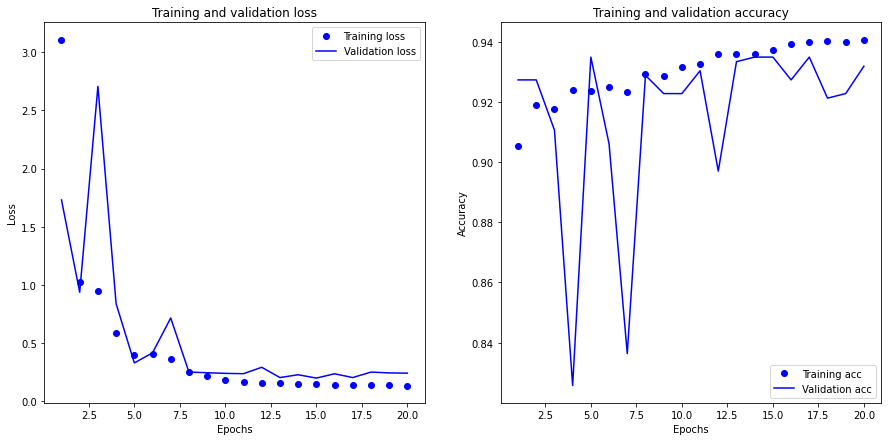

In [222]:
visualize_training(history)

In [223]:
print_test_result(model, test_x, test_y)

21/21 - 0s - loss: 0.2460 - accuracy: 0.9167
loss: 0.246
accuracy: 0.917
